# SSE algorithm for n-dimensional Heisenberg model

This program is a python implementation of quantum monte carlo method, using SSE algorithm to find properties of $S=\frac{1}{2}$ Heisenberg model of arbitary dimension at finite temperature.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%load_ext line_profiler
from numba import jit
import multiprocessing as mp
%config InlineBackend.figure_format = 'svg' 

## 1. General principles
We are interested in the partition function
$$
Z = \text{Tr}(e^{-\beta H})
$$

To calculate this, we use the Path Integral Quantum Monte Carlo(PIQMC) method and Taylor expansion, so we can rewrite the partition function as
$$
Z = \sum_{\alpha} \sum_{n=0}^{\infty} \frac{\beta^n}{n!} \langle \alpha | (-H)^n | \alpha \rangle
$$

The hamiltonian of interest is written as 
$$
H = -\sum_{a,b} H_{a,b}
$$
where $a$ refers to the operator type and $b$ refers to the bond index.

In the series expansion, the length $n$ is varying and makes coding difficult.
To deal with this, we choose a cut-off length $M$
(actually chosen by program auomatically to ensure the truncation error is negligble, which requires $M$ proportional to $\beta E$) 
and insert indentity operator $H_{0,0}$ to augment all strings with $n<M$ to length $M$。

The final form of partition function looks like
$$
Z = \sum_{\alpha} \sum_{\{H_{ab}\}} \frac{\beta^n (M-n)!}{M!} \left\langle \alpha \left| \prod_{i=1}^{M} H_{a(i),b(i)} \right|\alpha \right\rangle
$$

## 2. Bond lable

Every bond has to be mapped to a integer, so the final problem will always be a 1D problem.

In a n-D space, a site index looks like $ (i_1, i_2, \dots, i_n), i_k=0,1,\dots,L-1 $, and it has $2n$ bonds related to itself.
Every bond connects two sites, so with periodic boundary condition, every site has to label $n$ bonds.

The site $ (i_1, i_2, \dots, i_n) $ is labeled by
$$
\text{site} = i_1  + i_2 L +\dots + i_n L^{n-1}
$$
ranges from $0$ to $L^n-1$.

We define the bond which connects site1=$ (i_1, i_2, \dots, i_k, \dots, i_n) $ and site2=$ (i_1, i_2, \dots, i_k+1, \dots i_n) $ as 
$$
\text{bond} = \text{site1}*n + (k-1) +1 = \text{site1}*n + k
$$

In this coding, bond num ranges from $1$ to $nL^n$.

In [2]:
@jit(nopython=True)
def site_num(index, L):
    n = index.shape[0]
    s = (index * L**np.arange(n)).sum()
    return int(s)

@jit(nopython=True)
def site_index(num, n, L):
    index = np.zeros(n)
    for i in range(n):
        index[i] = num%L
        num = num//L
    return index

@jit(nopython=True)
def bond_num(site_num, n, k):
    return site_num*n+k

@jit(nopython=True)
def get_bond_sites(bond_num, n, L):
    site1 = int((bond_num-1)//n)
    k1 = int((bond_num-1)%n)

    site1_index = site_index(site1, n, L)
    site2_index = site1_index.copy()
    site2_index[k1] = (site2_index[k1]+1)%L
    site2 = site_num(site2_index, L)

    return site1, site2

## 3. Spin configuration and operator string
The original hamitonion of the antiferromagnetic Heisenberg model is
$$
H = J\sum_{\langle i,j \rangle} \mathbf{S}_i \cdot \mathbf{S}_j
$$
with $J>0$, so here we choose $J=1$.

We introduce the diagonal(a=1) and off-diagonal(a=2) bond operators:
$$
H_{1,b} = \frac{1}{4} - S^z_{i(b)}S^z_{j(b)}\\
H_{2,b} = \frac{1}{2}\left( S^{+}_{i(b)}S^{-}_{j(b)} + S^{-}_{i(b)}S^{+}_{j(b)} \right)
$$
in terms of which the hamitonian is 
$$
H = -\sum_{b=1}^{B} \sum_{a=1}^{2} H_{a,b}
$$

Only anti-parallel spins may contribute a factor $\frac{1}{2}$, otherwise $0$. 
This gives a constraint on the update process.

In the SSE algorithm, an element in the partition function look like
$$
\prod_{p=0}^{M-1} H_{a(p),b(p)}
$$
so it's natural to use an integer to encode both $a(p)$ and $b(p)$:
$$
\text{opstring[p]} = 2b(p) + a(p) -1
$$
and naturally if there's identity at p, opstring[p]=0.

We also need to store the spin configuration at the moment, and use it to construct the linked vertex list:
$$
\text{spin[i]} = 2S^z_i = 1 \, or \, -1
$$

## 4. Linked vertex list

For a bond operator, no matter what kind it is, we label the site1 of the input leg0, site2 of the input leg1,
site1 of the output leg2, and site2 of the output leg3.
In the program, we only need to know how the legs are linked instead of the spin configuration at any moment,
so it saves a lot of memory.
The vertex leg at bond p can be identified by an integer:
$$
v=4p+l(p)
$$
it ranges from $0$ to $4M-1$.

To construct the linked vertex list from opstring, we can store the first visited operator and last visited operator of every spin.

In [3]:
@jit(nopython=True)
def construct_vertexlist(opstring, n, L, beta):
    M = opstring.shape[0]
    frstspinop = np.zeros(L**n, dtype=np.int32)-1
    lastspinop = np.zeros(L**n, dtype=np.int32)-1
    vertexlist = np.zeros(4*M, dtype=np.int32)-1

    for v in np.arange(M)*4:  # v->v+4, visit each op only once
        p = v//4
        op = opstring[p]
        # if the op isnt identity
        if op!=0:
            bond = op//2
            site1, site2 = get_bond_sites(bond, n, L)
            v1 = lastspinop[site1]
            v2 = lastspinop[site2]

            # if site1 has visited some op
            if v1!=-1:
                vertexlist[v1] = v
                vertexlist[v] = v1
            else:
                frstspinop[site1] = v

            # if site2 has visited some op
            if v2!=-1:
                vertexlist[v2] = v+1
                vertexlist[v+1] = v2
            else:
                frstspinop[site2] = v+1

            # move on, update the visited op
            lastspinop[site1] = v+2
            lastspinop[site2] = v+3

        # the op is identity, vertex at this p should all be 0
        else:
            vertexlist[v:v+4] = -1

    # periodic boundary condition
    for spin in range(L**n):
        v1 = frstspinop[spin]
        if v1!=-1:
            v2 = lastspinop[spin]
            vertexlist[v1] = v2
            vertexlist[v2] = v1
    

    freespin = (frstspinop==-1)
    return vertexlist, freespin, frstspinop

## 5. Sampling
With two allowed configurations A and B, connected by one update, we have to find the probability of whether to accept the update.
In general, 
$$
P_{accept}(A\rightarrow B) = \text{min}\left(\frac{W(B) P_{select}(B\rightarrow A)}{W(A) P_{select}(A\rightarrow B)}, 1\right)
$$
where $W(A)$ is the weight of $A$ in $Z$.

In the diagonal update, the probability is simple to calculate.

In [4]:
@jit(nopython=True)
def P_accept_insert(B, beta, M, n):
    return min(B*beta/2/(M-n), 1)

@jit(nopython=True)
def P_accept_remove(B, beta, M, n):
    return min((M-n+1)*2/B/beta, 1)

## 6. Diagnol update
This is the only way to change operator number in the configuration.
We propagate the spin configuration according to ``opstring``,
and change ``opstring`` at the same time.
If there's already a diagonal operator, remove it with $P_{remove}$,
if there's no operator, choose a bond randomly and insert a diagonal operator with $P_{insert}$,
or thers's an off-diagonal operator, then just change the spin configuration .

In [5]:
@jit(nopython=True)
def diag_update(opstring, spin, n, L, beta):
    # number of hamiltonion
    nh = (opstring!=0).sum()
    M = opstring.shape[0]
    B = n*L**n

    am = 0
    am1 = am2 = 0

    # calculate the mag at first
    for i in range(spin.shape[0]):
        index = site_index(i, n, L)
        am += spin[i]*(-1)**np.sum(index)
    am /= 2

    for p in range(M):
        op = opstring[p]
        # op is identity, try to insert
        if op==0:
            prob = P_accept_insert(B, beta, M, nh)
            rand_bond = np.random.randint(1,B+1)
            site1, site2 = get_bond_sites(rand_bond, n, L)
            if spin[site1]!=spin[site2] and np.random.rand()<prob:
                opstring[p] = 2*rand_bond
                nh += 1
        
        # op is diag, try to remove
        elif op%2==0:
            prob = P_accept_remove(B, beta, M, nh)
            if np.random.rand()<prob:
                opstring[p] = 0
                nh -= 1

        # op is off-diag, only flip spin
        else:
            bond = op//2
            site1, site2 = get_bond_sites(bond, n, L)
            spin[site1] *= -1
            spin[site2] *= -1

            am += 2*spin[site1]*(-1)**np.sum(site_index(site1, n, L))
            
        am2 += am**2
        am1 += abs(am)

    am2 /= M
    am1 /= M
    
    return opstring, am1, am2

## 7. Spin update
There are two kinds of spin that might be flipped:
if the spin is in some loop that needs to be flipped, then the spin must be flipped;
or if the spin doesn't meet any operator, then this free spin should be flipped with some probability.

In [6]:
@jit(nopython=True)
def spin_update(spin, freespin, vertexlist, frstspinop):
    for s in range(spin.shape[0]):
        # flip free spin with prob
        if freespin[s] and np.random.rand()<0.5:
            spin[s] *= -1
        # flip spins in flipped loop
        elif vertexlist[frstspinop[s]]==-2:
            spin[s] *= -1

    return spin

## 8. Loop update
The whole vertex list can be splitted into loops, because every leg belongs and only belongs to one loop.
Therefore, we can flip each loop without changing the weight and the off-diagonal pairing.
This update method is much more efficient than flip one operator at a time.
Only changes ``opstring``, reconstruct the vertex list later.

We measure susceptibility while we go through the vertex list in loop update to save computation cost. This is an optimized estimator 
$$
\chi = \frac{\beta}{4N_{site}} \left\langle \sum_{\text{all loop}}
\left( \sum_{\text{site}=1}^{n_j} \phi_i \right)^2 \right\rangle
$$
which is better in statistical efficiency than the original one, as we'll see in the results.

In [7]:
@jit(nopython=True)
def off_diagonal_update(opstring, vertexlist, n, L, spin):
    v_num = vertexlist.shape[0]
    sus = 0
    M = opstring.shape[0]

    # dont need to start from spins that must be in the same loop
    for v_ini in range(0, v_num-1, 2):
        # vertex isnt in any loop
        if vertexlist[v_ini]<0:
            continue

        v1 = v_ini
        loop_sus = 0
        # choose whether to flip before loop search
        if np.random.rand()<0.5:
            while True:
                p1 = v1//4
                opstring[p1] = int(opstring[p1])^1  #change op type
                vertexlist[v1] = -2                 #v1 is visited，and spin need to be fliped
                v2 = v1^1                           #v2 is next to v1
                v1 = vertexlist[v2]                 #find the vertex linked with v2
                p2 = v1//4
                vertexlist[v2] = -2                 #v2 is visited

                # spin in the loop
                leg = v1%4

                if (p1<p2 and leg>1) or (p1>p2 and leg<2) or (p1==p2):
                    loop_sus += spin[get_bond_sites(opstring[p2]//2, n, L)[leg%2]]

                if v1==v_ini:
                    break
        else:
            while True:
                p1 = v1//4
                vertexlist[v1] = -3                 #v1 is visited
                v2 = v1^1                           #v2 is next to v1
                v1 = vertexlist[v2]                 #find the vertex linked with v2
                p2 = v1//4
                vertexlist[v2] = -3                 #v2 is visited

                # spin in the loop
                leg = v1%4

                if (p1<p2 and leg>1) or (p1>p2 and leg<2) or (p1==p2):
                    loop_sus += spin[get_bond_sites(opstring[p2]//2, n, L)[leg%2]]

                if v1==v_ini:
                    break

        sus += loop_sus**2
        
    return opstring, vertexlist, sus

## 9. Measurement

In [8]:
def correlation(spin, n, L, d):
    spin = spin.reshape([L]*n)
    c = 0
    for i in range(n):
        c += np.sum(np.roll(spin, d, axis=i) * spin)
    c /= n*L**n
    return c

In [32]:
def SSE_algo(inp):
    n, L, beta, warmup, Iter, need_cor, d = inp
    spin = np.ones(L**n, dtype=int)
    B = n*L**n
    opstring = np.zeros(10, dtype=int)
    sweep = 1
    c = 0
    nh_acc = nh2_acc = m_acc = m2_acc = ususc = cor = opt_ususc = free = 0

    for sweep in range(Iter):
        opstring, am1, am2= diag_update(opstring, spin, n, L, beta)
        vertexlist, freespin, frstspinop = construct_vertexlist(opstring, n, L, beta)
        opstring, vertexlist, sus = off_diagonal_update(opstring, vertexlist, n, L, spin)
        spin = spin_update(spin, freespin, vertexlist, frstspinop)

        nh = (opstring!=0).sum()
        if sweep>warmup:
            # measure sus and eng
            m2_acc += am2
            m_acc += am1
            ususc += (spin.sum()/2)**2

            nh_acc += nh
            nh2_acc += nh**2
            
            if need_cor:
                cor += correlation(spin, n, L, d)
            
            opt_ususc += sus + freespin.sum()
            free += freespin.sum()
            
            c += 1

        cutoff = opstring.shape[0]
        new_cutoff = 4*nh//3
            
        if new_cutoff>cutoff:
            new_opstring = np.zeros(new_cutoff)
            new_opstring[:cutoff] = opstring
            opstring = new_opstring

    nh_acc /= c
    nh2_acc /= c
    m2_acc /= c
    m_acc /= c
    ususc /= c
    cor /= c*4

    opt_ususc /= c
    free /= c

    energy = (-nh_acc/beta + B/4)/L**n
    cap = (nh2_acc-nh_acc-nh_acc**2)/L**n
    m2_acc *= 3/L**(2*n)
    m_acc *= 1/L**n
    ususc *= beta/L**n
    opt_ususc *= beta/4/L**n
    free *= beta/4/L**n

    return energy, cap, m_acc, m2_acc, ususc, cor, opt_ususc, free

In [10]:
def simulate(n, L, beta, warmup, Iter, need_cor=False, d=1, worker=-1):
    if worker==-1:
        worker = mp.cpu_count()-2
    
    inp = [n, L, beta, warmup, Iter, need_cor, d]
    with mp.Pool(processes=worker) as pool:
        res = pool.map(SSE_algo, [inp]*worker)
        res = np.array(res)
        ans = np.average(res, axis=0)
        err = np.sqrt((np.average(res**2, axis=0) - ans**2)/worker)
        return ans, err


## 10. Results

### Susceptibility of 2D 4 $\times$ 4 lattice

In [11]:
N = 20
T = np.linspace(0.1, 2, N)
beta = 1/T
res = []
err = []
for i in tqdm(range(N)):
    r, e = simulate(2,4,beta[i],10000,200000,need_cor=True)
    res.append(r)
    err.append(e)
res = np.array(res)
err = np.array(err)

100%|██████████| 20/20 [06:36<00:00, 19.84s/it]


Text(0, 0.5, 'C(1)')

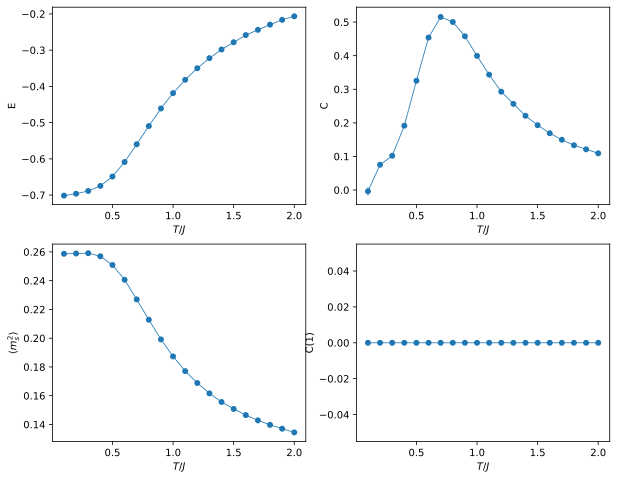

In [41]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.errorbar(T, res[:, 0], yerr=err[:, 0], fmt='-o', lw=0.8, mew=0.01)
ax1.set_xlabel(r'$T/J$')
ax1.set_ylabel('E')

ax2.errorbar(T, res[:, 1], yerr=err[:, 1], fmt='-o', lw=0.8, mew=0.01)
ax2.set_xlabel(r'$T/J$')
ax2.set_ylabel('C')

ax3.errorbar(T, res[:, 2], yerr=err[:, 2], fmt='-o', lw=0.8, mew=0.01)
ax3.set_xlabel(r'$T/J$')
ax3.set_ylabel(r'$\langle m_s^2 \rangle$')

ax4.errorbar(T, res[:, -3], yerr=err[:, -3], fmt='-o', lw=0.8, mew=0.01)
ax4.set_xlabel(r'$T/J$')
ax4.set_ylabel('C(1)')

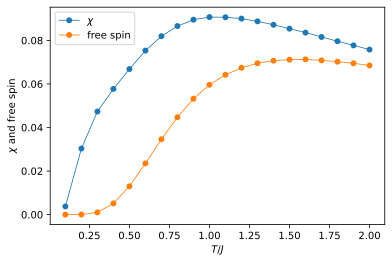

In [31]:
plt.plot(T, res[:, -2], '-o', label=r'$\chi$', lw=0.8, mew=0.01)
plt.plot(T, res[:, -1], '-o', label='free spin', lw=0.8, mew=0.01)
plt.xlabel(r'$T/J$')
plt.ylabel(r'$\chi$ and free spin')
plt.legend()
plt.show()

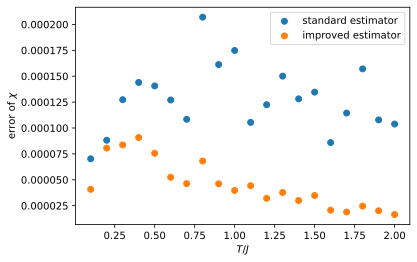

In [46]:
plt.scatter(T, err[:, -4], label='standard estimator')
plt.scatter(T, err[:, -2], label='improved estimator')
plt.legend()
plt.xlabel(r'$T/J$')
plt.ylabel(r'error of $\chi$')
plt.show()

### Magnetic susceptibility in different lattice

In [15]:
def plot_sus(n, L, Tmin, Tmax, N):
    T = np.linspace(Tmin, Tmax, N)
    beta = 1/T
    sus = np.zeros(N)
    for i in tqdm(range(N)):
        sus[i] = simulate(n, L, beta[i], 10000, 100000)[0][-2]
    plt.plot(T, sus, label=f'L={L}')

Simulating L=3


100%|██████████| 40/40 [09:28<00:00, 14.21s/it]


Simulating L=4


100%|██████████| 40/40 [10:34<00:00, 15.87s/it]


Simulating L=5


100%|██████████| 40/40 [11:51<00:00, 17.80s/it]


Simulating L=6


100%|██████████| 40/40 [13:31<00:00, 20.29s/it]


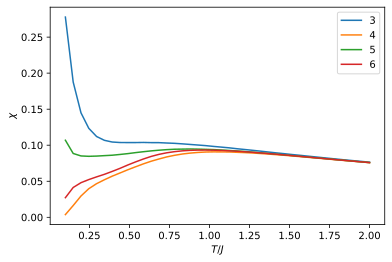

In [16]:
for l in np.arange(4)+3:
    print(f"Simulating L={l}")
    plot_sus(2, l, 0.1, 2, 40)
plt.legend()
plt.xlabel(r'$T/J$')
plt.ylabel(r'$\chi$')
plt.show()

100%|██████████| 40/40 [46:59<00:00, 70.48s/it]


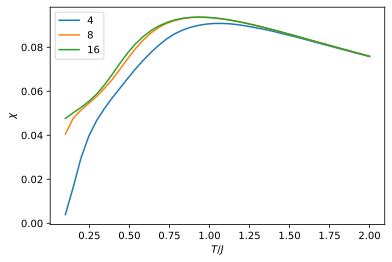

In [17]:
L6 = [4,8,16]
for l in L6:
    plot_sus(2, l, 0.1, 2, 40)
plt.legend()
plt.xlabel(r'$T/J$')
plt.ylabel(r'$\chi$')
plt.show()

### Ground state energy of 1D chain

In [26]:
m3 = np.arange(8, 13, 1)-8
res3 = []
err3 = []
for i in tqdm(m3):
    r, e = simulate(1, 4, 2**i, 100, 500)
    res3.append(r)
    err3.append(e)
res3 = np.array(res3)
err3 = np.array(err3)

100%|██████████| 5/5 [01:01<00:00, 12.35s/it]


In [29]:
res3 = np.array(res3)
err3 = np.array(err3)

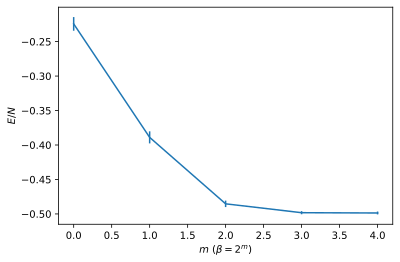

In [30]:
plt.errorbar(m3, -res3[:, 0], yerr=err3[:, 0], label=r'N=512')
plt.xlabel(r'$m$ ($\beta=2^m$)')
plt.ylabel(r'$-E/N$')
plt.show()

### Ground state $\langle m_s \rangle^2$ at different lattice

In [ ]:
N5 = 8
beta5 = 2**10
T5 = 1/beta5
L5 = np.arange(N5, dtype=np.int32)*2 + 8
res5 = []
for i in tqdm(range(N5)):
    res5.append(simulate(2, L5[i], beta5, 1000, 5000)[0])
res5 = np.array(res5)

100%|██████████| 4/4 [13:54<00:00, 208.70s/it]


In [ ]:
a, b = np.polyfit(1/L5, res5[:, 3], 1)
print(a, b)

0.7697671633469434 0.08343795622413545


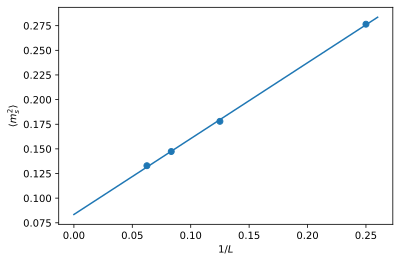

In [ ]:
plt.scatter(1/L5, res5[:, 3])
plt.plot(np.linspace(0, 0.26), a*np.linspace(0, 0.26)+b)
plt.xlabel(r'$1/L$')
plt.ylabel(r'$\langle m_s^2 \rangle$')

plt.show()